In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

\begin{table}[t]
    \centering
    \begin{tabular}[lcc]
        \toprule
        Group & Slope ($\pm$99\% CI) & $R^2$ \\
        \midrule
        all & 0.8225\textsubscript{$\pm$ 0.0104} & 0.9754 \\
        \midrule
        masked & 0.7759\textsubscript{$\pm$ 0.0167} & 0.9846 \\
        low-uniform & 0.7916\textsubscript{$\pm$ 0.0194} & 0.9811 \\
        balanced & 0.8373\textsubscript{$\pm$ 0.0214} & 0.9806 \\
        high-uniform & 0.8607\textsubscript{$\pm$ 0.0206} & 0.9832 \\
        uniform & 0.8787\textsubscript{$\pm$ 0.0160} & 0.9899 \\
        \midrule
        25.2M & 0.7847\textsubscript{$\pm$ 0.0202} & 0.9838 \\
        49.2M & 0.8148\textsubscript{$\pm$ 0.0220} & 0.9806 \\
        85.1M & 0.8395\textsubscript{$\pm$ 0.0180} & 0.9854 \\
        201.6M & 0.8127\textsubscript{$\pm$ 0.0175} & 0.9840 \\
        566.7M & 0.8365\textsubscript{$\pm$ 0.0163} & 0.9861 \\
        \bottomrule
    \end{tabular}
    \caption{Slope and $R^2$ values for optimal batch size vs. training tokens, grouped by noise type and model size. While the model size does not appear to have a strong effect on the scaling of optimal batch size, the noise type exhibits a consistent pattern of higher proportions of uniform noise requiring larger batch sizes to reach optimal performance.}
    \label{tab:optimal_batch_size_grouped}
\end{table}

\begin{table}[t]
    \centering
    \begin{tabular}[lcc]
        \toprule
        Group & Slope ($\pm$99\% CI) & $R^2$ \\
        \midrule
        all & 0.3412\textsubscript{$\pm$ 0.0110} & 0.9089 \\
        \midrule
        masked & 0.3295\textsubscript{$\pm$ 0.0286} & 0.8846 \\
        low-uniform & 0.2924\textsubscript{$\pm$ 0.0290} & 0.8360 \\
        balanced & 0.3653\textsubscript{$\pm$ 0.0207} & 0.9437 \\
        high-uniform & 0.3628\textsubscript{$\pm$ 0.0190} & 0.9489 \\
        uniform & 0.3554\textsubscript{$\pm$ 0.0151} & 0.9643 \\
        \midrule
        25.2M & 0.3422\textsubscript{$\pm$ 0.0202} & 0.9326 \\
        49.2M & 0.4606\textsubscript{$\pm$ 0.0637} & 0.8286 \\
        85.1M & 0.3293\textsubscript{$\pm$ 0.0193} & 0.9235 \\
        201.6M & 0.3279\textsubscript{$\pm$ 0.0158} & 0.9449 \\
        566.7M & 0.3340\textsubscript{$\pm$ 0.0327} & 0.8729 \\
        \bottomrule
    \end{tabular}
    \caption{Slope and $R^2$ values for optimal learning rate vs. training tokens, grouped by noise type and model size. Neither model size nor noise type appear to have a significant effect on the scaling of optimal learning rate.}
    \label{tab:optimal_learning_rate_grouped}
\end{table}


In [2]:
from notebooks.utils import load_runs

In [3]:
from notebooks.utils import flops_per_token

fpt = flops_per_token(24, 2048, 16, 2048, include_embed_flops=False)

print(f"{fpt:.4g} FLOPs per token, {9e9*fpt:.4g} total FLOPs")

8.463e+09 FLOPs per token, 7.617e+19 total FLOPs


In [4]:
from notebooks.utils import deduplicate_runs

deduplicate_runs({"tags": "cooldown_exp_1"}, dry_run=True)

Dry run: not deleting any runs
- Will keep 80 runs (80 finished, 0 running, 0 crashed)
- Will delete 19 runs (1 finished, 0 running, 18 crashed)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/dz9x7vlv (finished)> (duplicate group: name=gidd-L8-D512-H8-N2048-bs=32-T=64k-lr=0.1-cd=0.2)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/lcuvsr0b (crashed)> (duplicate group: name=gidd-L12-D768-H12-N2048-bs=32-T=64k-lr=0.1-cd=0.2)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/rvsr1op2 (crashed)> (duplicate group: name=gidd-L8-D512-H8-N2048-bs=256-T=8k-lr=0.3-cd=0.2)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/k0vn63w9 (crashed)> (duplicate group: name=gidd-L12-D768-H12-N2048-bs=256-T=8k-lr=2.0-cd=0.0)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/lfu7l6pc (crashed)> (duplicate group: name=gidd-L8-D512-H8-N2048-bs=256-T=8k-lr=2.0-cd=0.0)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/4rxyyepf (crashed)> (duplicate group: name=gidd-L12-D7

### Cooldown exp. 1

In [5]:
runs, histories, config_df = load_runs(
    filters={
        "tags": "cooldown_exp_1",
        "state": "finished",
    },
    order="config.batch_size",
    drop_duplicates=["num_layers", "batch_size", "lr", "cooldown_steps"],
)
len(runs)

Processing runs:   0%|          | 0/81 [00:00<?, ?it/s]

80

In [6]:
has_cooldown = []
no_cooldown = []
c = []

for i, ((layers, batch_size, lr), dfi) in enumerate(config_df.groupby(["num_layers", "batch_size", "lr"])):
    dfi = dfi.sort_values("cooldown_steps")
    losses = [histories[j]["train/elbo"].iloc[-10:].mean() for j in dfi.index]
    no_cooldown.append(losses[0])
    has_cooldown.append(losses[1])
    c.append(batch_size)
has_cooldown = np.array(has_cooldown)
no_cooldown = np.array(no_cooldown)
c = np.log(np.array(c))

In [7]:
ratio = no_cooldown/has_cooldown
mean = np.mean(ratio)
std = np.std(ratio)

# compute 95% confidence interval
# ci = 1.96 * std / np.sqrt(len(ratio))
# compute 99% confidence interval
ci = 2.576 * std / np.sqrt(len(ratio))
print(f"Mean ratio: {mean:.4f} (99% CI: ±{ci:.3g})")

Mean ratio: 1.0245 (99% CI: ±0.00138)


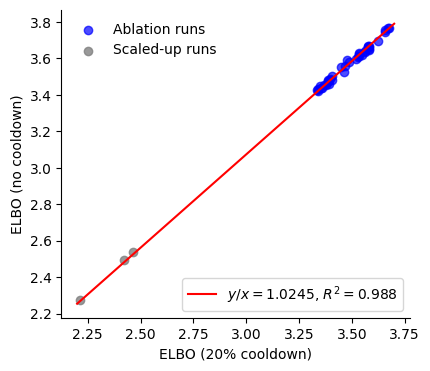

In [8]:
fig, ax = plt.subplots(figsize=(4.5, 4))

x = has_cooldown[:, None]
y = no_cooldown
a, _, _, _ = np.linalg.lstsq(x, y)
xs = np.linspace(2.2, 3.7, 100)
ys = a[0] * xs
r2 = np.corrcoef(has_cooldown, no_cooldown)[0, 1] ** 2
ax.plot(xs, ys, color="red", linestyle="-", label=f"$y/x = {a[0]:.4f}$, $R^2={r2:.3f}$")
artist = ax.legend(loc="lower right")
ax.add_artist(artist)

ax.scatter(has_cooldown, no_cooldown, c="blue", alpha=0.7, label="Ablation runs")
ax.scatter([2.462, 2.214, 2.422], [2.538, 2.275, 2.495], color="gray", alpha=0.8, label="Scaled-up runs")
# ax.scatter([2.462, 2.214, 2.422], [2.564, 2.301, 2.514], color="gray", alpha=0.8, label="Scaled up runs")

# draw separate legend for scatter points, making sure it does not obscure the line legend
handles, labels = ax.get_legend_handles_labels()
scatter_handles = [handles[1], handles[2]]
scatter_labels = [labels[1], labels[2]]
ax.legend(scatter_handles, scatter_labels, loc="upper left", frameon=False)

# plt.xscale("log")
# plt.yscale("log")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.3)

ax.set_xlabel("ELBO (20% cooldown)")
ax.set_ylabel("ELBO (no cooldown)")
fig.savefig("plots/cooldown_ablations_correlation.pdf", bbox_inches="tight")

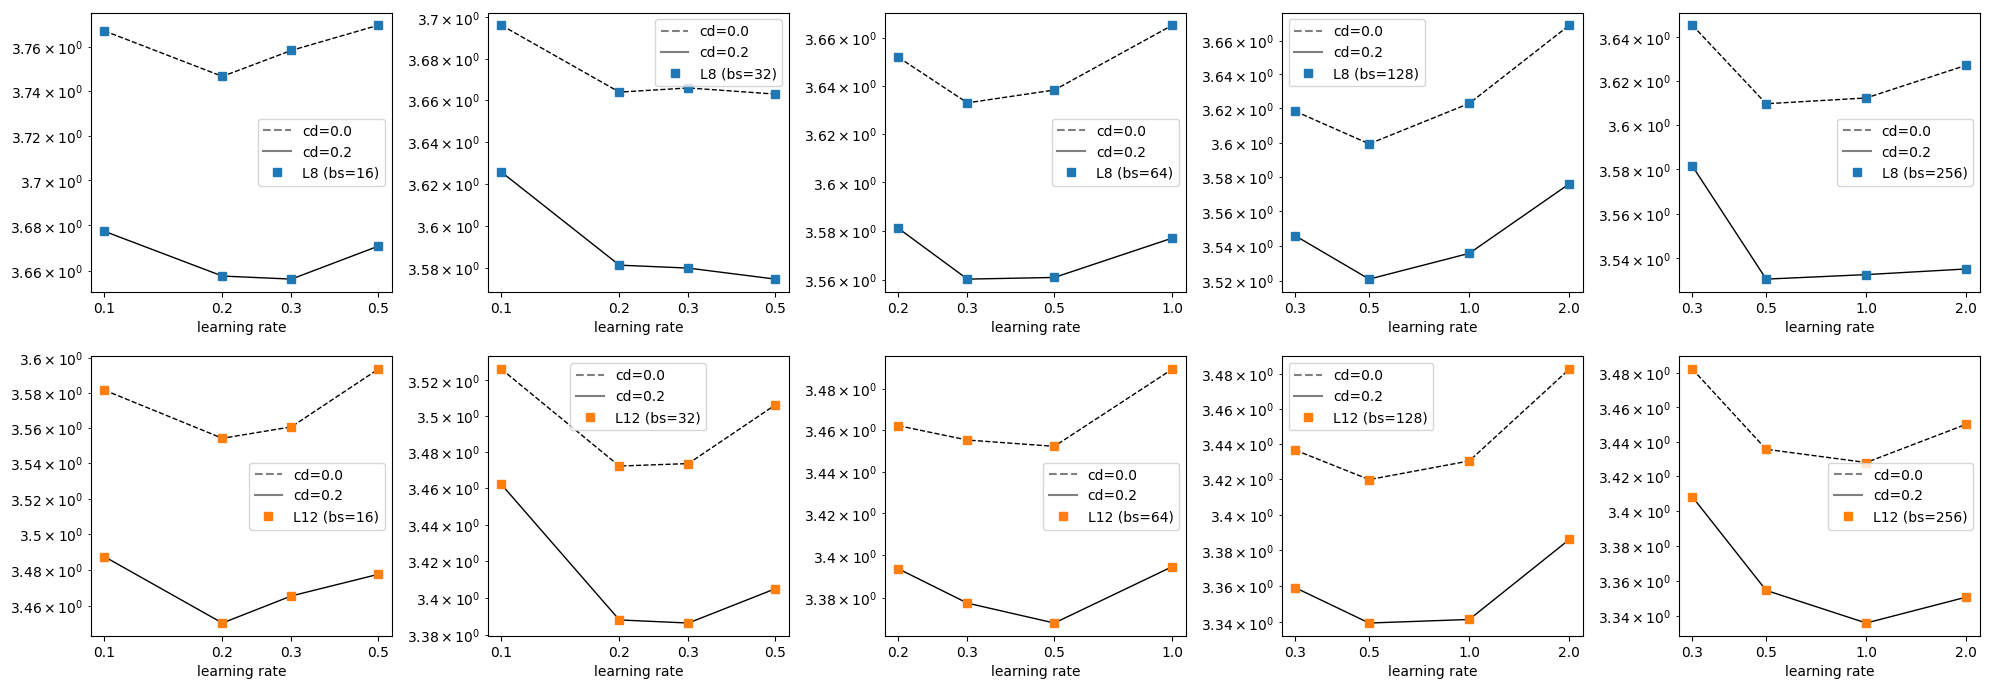

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(20, 7))

optimal_ids = []

for j, (num_layers, dfi) in enumerate(config_df.groupby("num_layers")):
    for i, (batch_size, dfj) in enumerate(dfi.groupby("batch_size")):
        ax = axs[j, i]
        for k, (cooldown, dfk) in enumerate(dfj.groupby("cooldown_steps")):
            dfk = dfk.sort_values("lr")
            xs = dfk["lr"].values
            ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfk.index])

            optimal_idx = dfk.index[np.argmin(ys)]
            optimal_ids.append(optimal_idx)

            linestyle = "-" if cooldown == 0.2 else "--"
            # if j == 0:
            ax.plot([], [], label=f"cd={cooldown}", linestyle=linestyle, color=f"gray")
            # ax.plot(xs, ys, label=f"L{num_layers} (bs={batch_size})" if cooldown == 0.2 else None, linestyle=linestyle, color=f"C{j}", marker="s")
            ax.plot(xs, ys, linestyle=linestyle, color="black", linewidth=1.0, marker="none")
            ax.plot(xs, ys, label=f"L{num_layers} (bs={batch_size})" if cooldown == 0.2 else None, linestyle="none", color=f"C{j}", marker="s")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xticks(sorted(set(xs)), [f"{x}" for x in sorted(set(xs))], minor=False)
        ax.set_xticks([], [], minor=True)
        ax.set_xlabel("learning rate")
        ax.legend()

fig.tight_layout()
fig.show()     

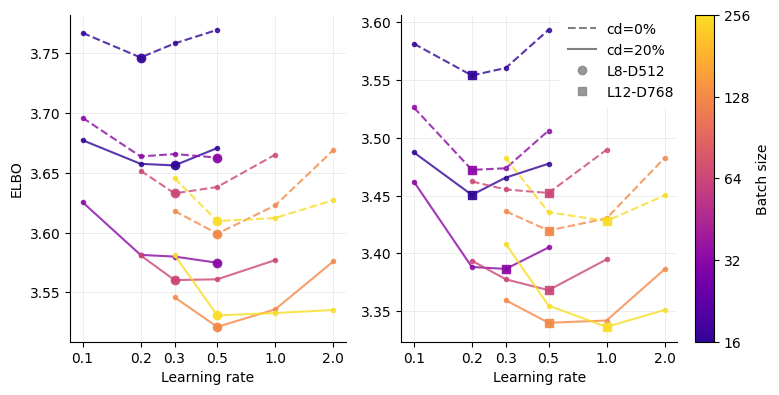

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4), sharey=False)

optimal_ids = []

vmin, vmax = config_df["batch_size"].min(), config_df["batch_size"].max()

xticks = sorted(config_df["lr"].unique())
bs_ticks = sorted(config_df["batch_size"].unique())


cmap = "plasma"
norm = plt.Normalize(vmin=np.log(vmin)-0.2, vmax=np.log(vmax)+0.2)

def color(x):
    # return cmap((np.log(x) - np.log(vmin)) / (np.log(vmax) - np.log(vmin)))
    return plt.get_cmap(cmap)(norm(np.log(x)))

for j, (num_layers, dfi) in enumerate(config_df.groupby("num_layers")):
    ax = axs[j]
    if j == 1:
        ax.plot([], [], label=f"cd=0%", linestyle="--", color=f"gray")
        ax.plot([], [], label=f"cd=20%", linestyle="-", color=f"gray")
        ax.plot([], [], label=f"L8-D512", linestyle="none", color=f"gray", marker="o", alpha=0.8)
        ax.plot([], [], label=f"L12-D768", linestyle="none", color=f"gray", marker="s", alpha=0.8)
        ax.legend(bbox_to_anchor=(1.04, 1.02), loc='upper right', fancybox=False, frameon=True, facecolor="white", borderpad=0.5, edgecolor="white", framealpha=1.0)
        # ax.legend()
    for i, (batch_size, dfj) in enumerate(dfi.groupby("batch_size")):
        for k, (cooldown, dfk) in enumerate(dfj.groupby("cooldown_steps")):
            dfk = dfk.sort_values("lr")
            xs = dfk["lr"].values
            ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfk.index])

            optimal_idx = dfk.index[np.argmin(ys)]
            optimal_ids.append(optimal_idx)
            opt_x = dfk.loc[optimal_idx, "lr"]
            opt_y = ys[np.argmin(ys)]

            linestyle = "-" if cooldown == 0.2 else "--"
            # if j == 0:
            # ax.plot(xs, ys, label=f"L{num_layers} (bs={batch_size})" if cooldown == 0.2 else None, linestyle=linestyle, color=f"C{j}", marker="s")
            ax.plot(xs, ys, linestyle=linestyle, color=color(batch_size), marker=".", alpha=0.8)
            ax.plot(opt_x, opt_y, linestyle=linestyle, color=color(batch_size), marker="o" if j == 0 else "s", alpha=0.9)
            # ax.plot(xs, ys, label=f"L{num_layers} (bs={batch_size})" if cooldown == 0.2 else None, linestyle="none", color=f"C{j}", marker="s")

    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_xticks(xticks, [f"{x}" for x in xticks], minor=False)
    ax.set_xticks([], [], minor=True)
    ax.set_xlabel("Learning rate")

    if j == 0:
        ax.set_ylabel("ELBO")

    ax.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.3)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


fig.tight_layout()

box = axs[-1].get_position()
cax_w, pad = 0.028, 0.025
cax = fig.add_axes([box.x0 + box.width + pad, box.y0, cax_w, box.height])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cb = fig.colorbar(sm, cax=cax, label="Batch size")
cax.set_ylim(np.log(vmin), np.log(vmax))
cax.yaxis.set_ticks(np.log(bs_ticks), [f"{x}" for x in bs_ticks])
cax.yaxis.set_ticks_position('right'); cax.yaxis.set_label_position('right')

fig.show()
fig.savefig("plots/cooldown_ablations_elbo_vs_lr.pdf", bbox_inches="tight")

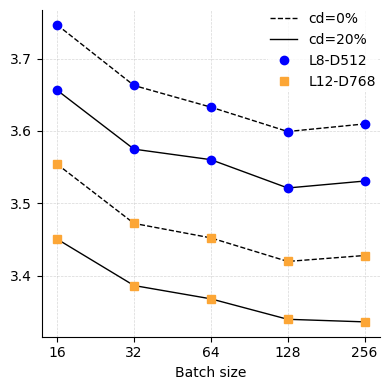

In [55]:
optimal_df = config_df.loc[optimal_ids]

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)

ax.plot([], [], label=f"cd=0%", linestyle="--", color=f"black", linewidth=1.0)
ax.plot([], [], label=f"cd=20%", linestyle="-", color=f"black", linewidth=1.0)

colors = ["blue", plt.cm.plasma(0.8)]
markers = ["o", "s"]

ax.plot([], [], label=f"L8-D512", linestyle="none", marker=markers[0], color=colors[0], linewidth=1.0)
ax.plot([], [], label=f"L12-D768", linestyle="none", marker=markers[1], color=colors[1], linewidth=1.0)

for j, (cooldown, dfi) in enumerate(optimal_df.groupby("cooldown_steps")):
    for i, ((num_layers, hidden_size), dfj) in enumerate(dfi.groupby(["num_layers", "hidden_size"])):
        dfj = dfj.sort_values("batch_size")
        xs = dfj["batch_size"].values
        ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfj.index])

        linestyle = "-" if cooldown == 0.2 else "--"
        # if j == 0:
        ax.plot(xs, ys, linestyle=linestyle, color="black", linewidth=1.0, marker="none")
        ax.plot(xs, ys, linestyle="none", color=colors[i], marker=markers[i])

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xticks(sorted(set(xs)), [f"{x}" for x in sorted(set(xs))], minor=False)
ax.set_xticks([], [], minor=True)
ax.set_xlabel("Batch size")
ax.legend(bbox_to_anchor=(1.013, 1.02), loc='upper right', fancybox=False, facecolor="white", borderpad=0.1, edgecolor="white", framealpha=0.8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

fig.tight_layout()
fig.show()

fig.savefig("plots/cooldown_ablations_elbo_vs_bs.pdf", bbox_inches="tight")

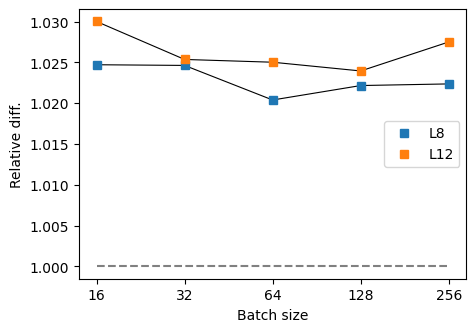

In [13]:
optimal_df = config_df.loc[optimal_ids]

fig = plt.figure(figsize=(5, 3.5))
ax = fig.add_subplot(1, 1, 1)

plt_idx = 1
for i, (num_layers, dfi) in enumerate(optimal_df.groupby("num_layers")):
    plt_idx += 1
    dfi = dfi.sort_values("batch_size")
    xs = dfi[dfi["cooldown_steps"] == 0.2]["batch_size"].values

    elbo_w_cd = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfi[dfi["cooldown_steps"] == 0.2].index])
    elbo_wo_cd = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfi[dfi["cooldown_steps"] == 0.0].index])
    ys = elbo_wo_cd / elbo_w_cd

    # ax.plot([], [], label=f"cd={cooldown}", linestyle=linestyle, color=f"black", linewidth=1.0)
    ax.plot(xs, ys, linestyle=linestyle, color="black", linewidth=0.8, marker="none")
    ax.plot(xs, ys, label=f"L{num_layers}" if cooldown == 0.2 else None, linestyle="none", color=f"C{i}", marker="s")


    for j, (cooldown, dfj) in enumerate(dfi.groupby("cooldown_steps")):
        xs = dfj["batch_size"].values
        ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfj.index])

        linestyle = "-" if cooldown == 0.2 else "--"
        # if j == 0:

ax.plot(xs, [1.0 for _ in xs], linestyle="--", color="gray")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xticks(sorted(set(xs)), [f"{x}" for x in sorted(set(xs))], minor=False)
ax.set_xticks([], [], minor=True)
ax.set_xlabel("Batch size")
ax.set_ylabel("Relative diff.")
ax.legend()

fig.show()

### Cooldown exp. 2

In [14]:
runs_2, histories_2, config_df_2 = load_runs(
    filters={
        "tags": "cooldown_exp_2",
        "state": "finished",
    },
    order="config.batch_size",
)
len(runs)

Processing runs:   0%|          | 0/49 [00:00<?, ?it/s]

80

In [15]:
config_df_2.loc[(config_df["lr"] == 0.3) & (config_df["cooldown_steps"] == 0.0)]["name"].tolist()

['gidd-L12-D768-H12-N2048-bs=32-T=64k-lr=0.2-cd=0.2',
 'gidd-L8-D512-H8-N2048-bs=32-T=64k-lr=0.5-cd=0.2',
 'gidd-L8-D512-H8-N2048-bs=32-T=64k-lr=0.1-cd=0.2',
 'gidd-L8-D512-H8-N2048-bs=32-T=64k-lr=2.0-cd=0.2',
 'gidd-L8-D512-H8-N2048-bs=32-T=16k-lr=0.2-cd=0.2']

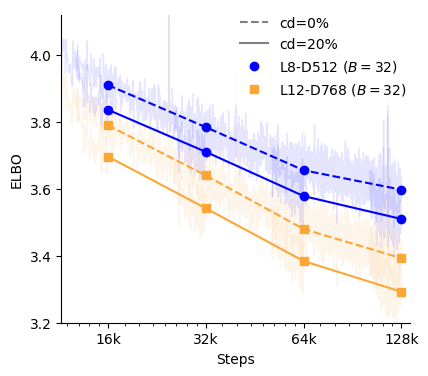

In [53]:
fig = plt.figure(figsize=(4.5, 4))
ax = fig.add_subplot(1, 1, 1)

dfi = config_df_2.loc[(config_df_2["lr"] == 0.3)]

dfi = dfi.sort_values("max_training_steps")

xticks = sorted(dfi["max_training_steps"].unique())

colors = ["blue", plt.cm.plasma(0.8)]
markers = ["o", "s"]

for i, (num_layers, dfj) in enumerate(dfi.groupby("num_layers")):
    dfk = dfj.loc[dfj["cooldown_steps"] == 0.2]
    color = colors[i]
    final_steps = []
    final_losses = []
    for j, idx in enumerate(dfk.index):
        history = histories_2[idx]
        final_steps.append(history["_step"].iloc[-1])
        final_losses.append(history["train/elbo"].iloc[-5:].mean())
        cooldown_start = history["_step"].iloc[-1] * (1 - dfk.loc[idx, "cooldown_steps"])
        h = history.loc[history["_step"] >= cooldown_start]
        ax.plot(h["_step"], h["train/elbo"], alpha=0.1, color=color, linewidth=1.0)
        # ax.plot(h["_step"], h["train/elbo_ema"], color=color, alpha=0.2)

    # plt.plot(final_steps, final_losses, marker="none", linestyle="-", color="black", linewidth=0.75, alpha=0.9, zorder=2)
    # plt.plot(final_steps, final_losses, marker=markers[i], linestyle="none", color=color, zorder=5)
    plt.plot(final_steps, final_losses, marker=markers[i], linestyle="-", color=color, zorder=5)

    dfk = dfj.loc[dfj["cooldown_steps"] == 0.0]
    idx = dfk.index[0]
    h = histories_2[idx]
    color = colors[i]
    ax.plot(h["_step"], h["train/elbo"], alpha=0.1, color=color, linewidth=1.0)
    # ax.plot(h["_step"], h["train/elbo_ema"], color=color, alpha=0.2)
    # ax.plot(h["_step"], h["train/elbo_fit"], color=color, alpha=1.0, linestyle="--")

    final_losses = []
    for step in final_steps:
        h_ = h.loc[h["_step"] <= step]
        final_losses.append(h_["train/elbo"].iloc[-5:].mean())
    plt.plot(final_steps, final_losses, marker=markers[i], linestyle="--", color=color, zorder=3)

# dfi = config_df_2.loc[(config_df_2["lr"] == 0.3) & (config_df_2["cooldown_steps"] == 0.0)]
# for i, (num_layers, dfj) in enumerate(dfi.groupby("num_layers")):
#     idx = dfj.index[0]
#     h = histories_2[idx]
#     color = colors[i]
#     ax.plot(h["_step"], h["train/elbo"], alpha=0.1, color=color, linewidth=1.0)
#     ax.plot(h["_step"], h["train/elbo_ema"], color=color, alpha=0.3, linewidth=1.0)
#     # ax.plot(h["_step"], h["train/elbo_fit"], color=color, alpha=1.0, linestyle="--")

ax.plot([], [], linestyle="--", color="gray", label="cd=0%")
ax.plot([], [], linestyle="-", color="gray", label="cd=20%")
ax.plot([], [], linestyle="none", marker=markers[0], color=colors[0], label="L8-D512 ($B=32$)")
ax.plot([], [], linestyle="none", marker=markers[1], color=colors[1], label="L12-D768 ($B=32$)")
# ax.plot([], [], linestyle="-", color="gray", label="smoothed (EMA 0.96)")
ax.set_ylabel("ELBO")
ax.set_xlabel("Steps")
ax.legend()

minor_xticks = (
    [8000 + i * 1000 for i in range(8)]
    + [16000 + i * 2000 for i in range(8)]
    + [32000 + i * 4000 for i in range(8)]
    + [64000 + i * 8000 for i in range(8)]
    + [128000 + i * 16000 for i in range(8)]
)

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xticks(xticks, [f"{x//1000}k" for x in xticks], minor=False)
ax.set_xticks(minor_xticks, ["" for x in minor_xticks], minor=True)
# ax.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.5)
# ax.grid(True, which="minor", linestyle=":", linewidth=0.9, alpha=0.2)

ax.legend(bbox_to_anchor=(1.03, 1.04), loc='upper right', fancybox=False, facecolor="white", borderpad=0.5, edgecolor="white", framealpha=0.8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(11500, 136000)
ax.set_ylim(3.2, 4.12)

fig.savefig("plots/cooldown_ablations_elbo_vs_steps.pdf", bbox_inches="tight")